**Подготовлено Анастасией Щепанской**

# **Задание**


🎯 Решите задачу предсказания выживаемости пассажиров на основе датасета “Титаник”, 
используя модели CatBoost, XGBoost и LightGBM.

1.Постройте модели на основе каждого из алгоритмов: CatBoost, XGBoost и LightGBM.

2.Сравните результаты работы моделей по основным метрикам: accuracy, precision, recall, F1-score.

3.Для лучшей интерпретации модели визуализируйте несколько деревьев из каждой модели.

4.Сделайте выводы о том, какие признаки наиболее важны в каждой модели
и какая из моделей показала наилучшие результаты.

📚 Датасет: **Titanic** Dataset https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

## Построение модели

In [220]:
!pip install catboost -q
!pip install xgboost -q
!pip install lightgbm -q

In [221]:
!pip install graphviz

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier, plot_tree as plot_xgboost_tree
from lightgbm import LGBMClassifier, plot_tree as plot_lightgbm_tree

In [223]:
# Загрузка данных
data = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Просмотр первых строк
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [224]:
# Удаляем ненужные столбцы
data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Обрабатываем пропущенные значения
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Преобразуем категориальные признаки
categorical_features = ['Sex', 'Embarked']
data = pd.get_dummies(data, columns=categorical_features)

# Целевая переменная и признаки
X = data.drop('Survived', axis=1)
y = data['Survived']

In [225]:
# Посмотрим на типы признаков
print(X.dtypes)

Pclass          int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Sex_female      uint8
Sex_male        uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object


## Оценка моделей

Разобъем данные на тренировочную и тестовую часть. На тренировочной части по кросс-валидации проверим качество на тестовой части.

In [226]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение моделей c параметрами по умолчанию
cat_model = CatBoostClassifier()
xgb_model = XGBClassifier()
lgb_model = LGBMClassifier()

# Словарь для хранения моделей
models = {'CatBoost': cat_model, 'XGBoost': xgb_model, 'LightGBM': lgb_model}
results = {}

# Определение метрик для кросс-валидации
scoring_metrics = {
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1-score': make_scorer(f1_score)
}

# Кросс-валидация для каждой модели
for name, model in models.items():
    results[name] = {}
    for metric_name, metric in scoring_metrics.items():
        scores = cross_val_score(model, X, y, cv=3, scoring=metric, verbose=0)
        results[name][metric_name] = scores.mean()
    
    # Обучение модели на обучающей выборке
    model.fit(X_train, y_train)
print(results)

Learning rate set to 0.008248
0:	learn: 0.6880572	total: 1.53ms	remaining: 1.53s
1:	learn: 0.6821114	total: 3.67ms	remaining: 1.83s
2:	learn: 0.6773657	total: 5.66ms	remaining: 1.88s
3:	learn: 0.6713452	total: 9.93ms	remaining: 2.47s
4:	learn: 0.6652166	total: 11.9ms	remaining: 2.37s
5:	learn: 0.6598167	total: 14ms	remaining: 2.31s
6:	learn: 0.6537250	total: 16.1ms	remaining: 2.28s
7:	learn: 0.6485311	total: 18.2ms	remaining: 2.25s
8:	learn: 0.6423890	total: 20.6ms	remaining: 2.26s
9:	learn: 0.6367372	total: 24.5ms	remaining: 2.42s
10:	learn: 0.6321929	total: 26.3ms	remaining: 2.36s
11:	learn: 0.6277282	total: 28.5ms	remaining: 2.34s
12:	learn: 0.6238175	total: 29.8ms	remaining: 2.26s
13:	learn: 0.6186255	total: 31.8ms	remaining: 2.24s
14:	learn: 0.6139881	total: 33.9ms	remaining: 2.22s
15:	learn: 0.6110951	total: 35.5ms	remaining: 2.18s
16:	learn: 0.6063869	total: 38.6ms	remaining: 2.23s
17:	learn: 0.6016587	total: 40.8ms	remaining: 2.22s
18:	learn: 0.5972181	total: 42.7ms	remaining: 

In [227]:
# Преобразование результатов в DataFrame
results_df = pd.DataFrame(results).T
print(results_df.round(4))


          Accuracy  Precision  Recall  F1-score
CatBoost    0.8193     0.8066  0.6959    0.7464
XGBoost     0.8002     0.7585  0.7018    0.7288
LightGBM    0.8204     0.7976  0.7135    0.7531


**Выводы:**

LightGBM демонстрирует наилучшие результаты по точности и F1-score, что делает его предпочтительным выбором для данной задачи.

CatBoost показывает наилучшие результаты по точности, но уступает в полноте и F1-score.

XGBoost имеет наилучший показатель полноты, но его точность и F1-score ниже, чем у других моделей.

В дальнейшем рекомендуются выполнить подбор гиперпараметров для лучшего качества.

## Визуализация деревьев

Визуализируем несколько деревьев, чтобы увидеть, как они эволюционируют в процессе обучения для каждой модели. Это может помочь в понимании того, как модель улучшает свои предсказания.

In [228]:
# Для понимания процесса визуализации выберем глубину дерева 4

# Определение моделей для глубины дерева 4
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.05, depth=4, verbose=0)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4)
lgb_model = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, verbosity=-1)

# Словарь для хранения моделей
models = {'CatBoost': cat_model, 'XGBoost': xgb_model, 'LightGBM': lgb_model}
results = {}

for name, model in models.items():   
    # Обучение модели на обучающей выборке
    model.fit(X_train, y_train)

**CatBoost**

In [229]:
from sklearn.tree import plot_tree

In [230]:
from graphviz import Digraph
from IPython.display import Image, display

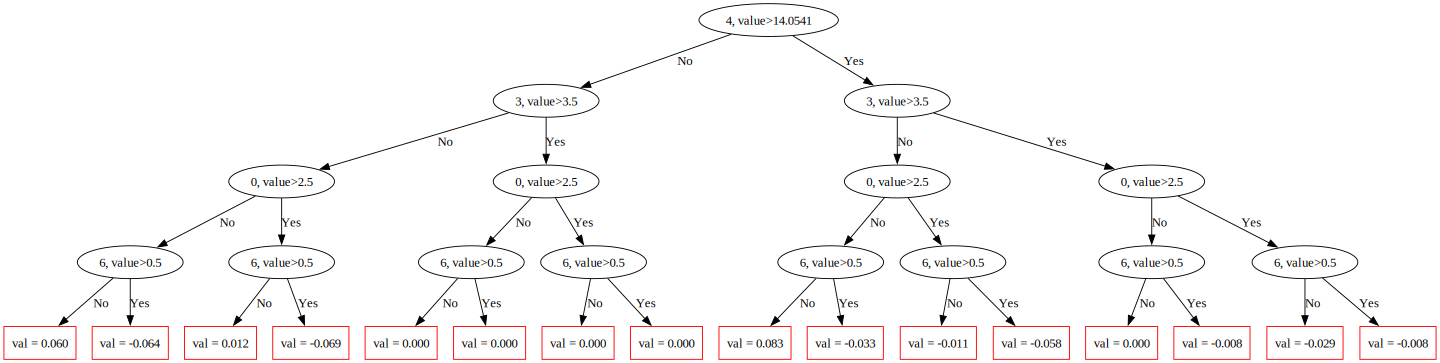

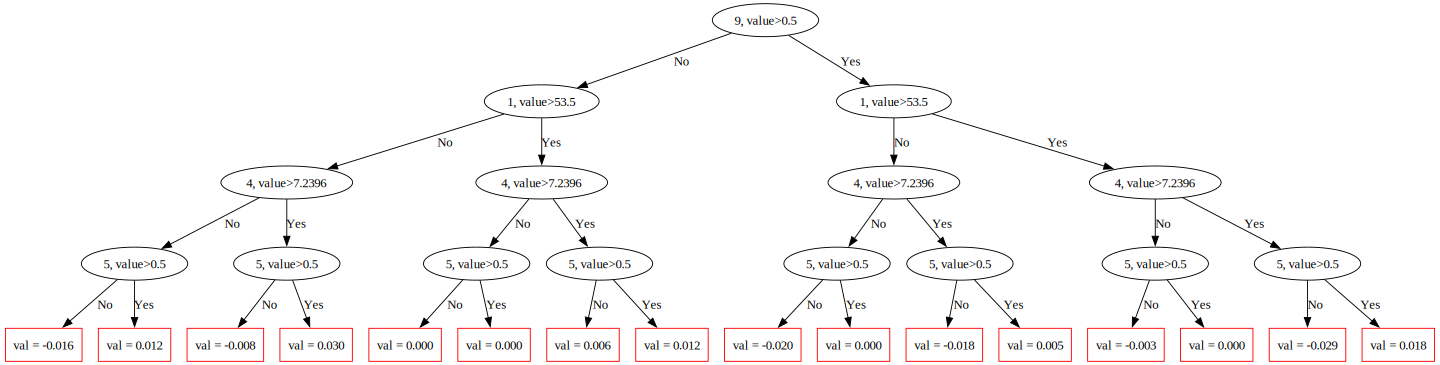

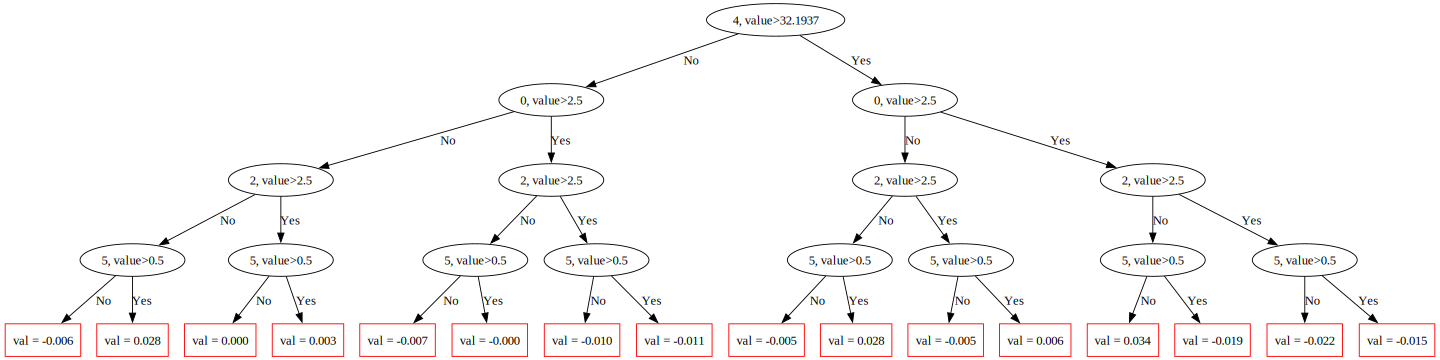

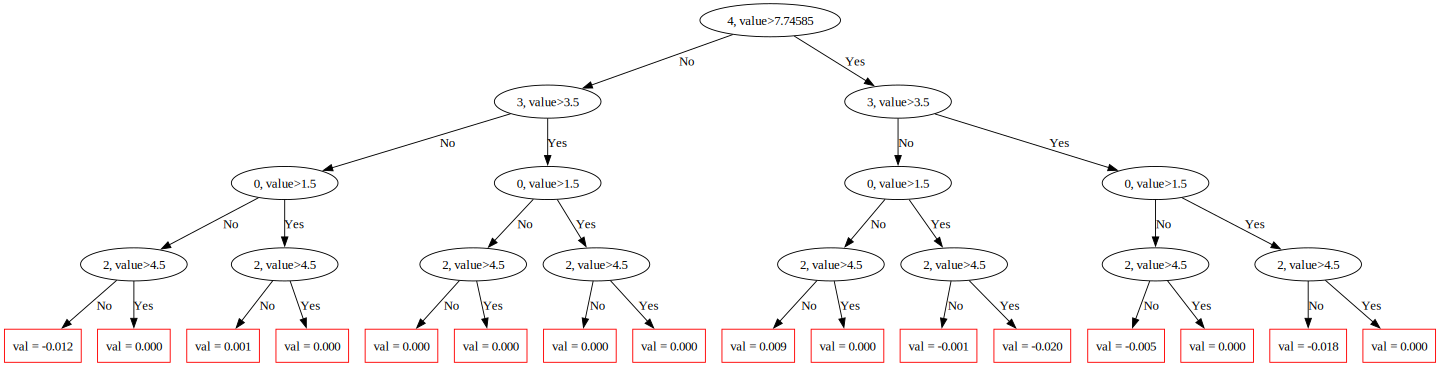

In [231]:
for i in range(0, 100, 33):  # Визуализируем несколько деревьев
    tree = models['CatBoost'].plot_tree(i)
    # Задание параметров изображения
    tree.attr(size='20,15')  # Установка размера изображения (ширина, высота)
    tree.attr(rankdir='UD')  # Установка направления (сверху вниз)
    display(tree)

**XGBoost**

<Figure size 2160x1440 with 0 Axes>

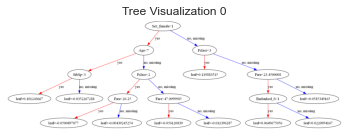

<Figure size 2160x1440 with 0 Axes>

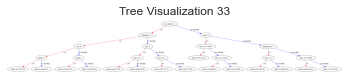

<Figure size 2160x1440 with 0 Axes>

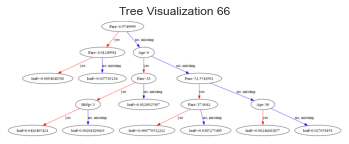

<Figure size 2160x1440 with 0 Axes>

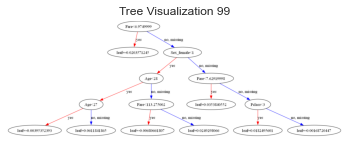

In [232]:
# Для XGBoost:
from xgboost import plot_tree, plot_importance
import matplotlib.pyplot as plt


for i in range(0, 100, 33):  # Визуализируем несколько деревьев
    plt.figure(figsize=(30, 20))
    plot_tree(models['XGBoost'], num_trees=i)
    plt.title(f"Tree Visualization {i}")
    plt.show()

<Figure size 1440x1080 with 0 Axes>

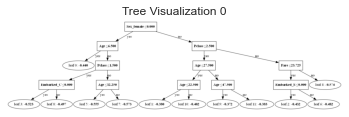

<Figure size 1440x1080 with 0 Axes>

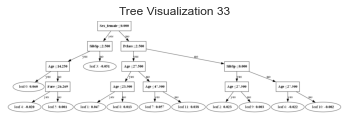

<Figure size 1440x1080 with 0 Axes>

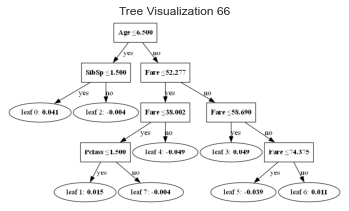

<Figure size 1440x1080 with 0 Axes>

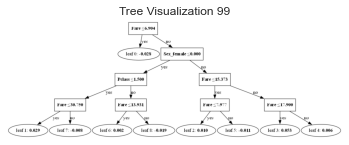

In [233]:
# Для LightGBM:
from lightgbm import plot_tree


for i in range(0, 100, 33):
    plt.figure(figsize=(20, 15))
    plot_tree(models['LightGBM'], tree_index=i, orientation='vertical')
    plt.title(f"Tree Visualization {i}")
    plt.show()
    

**Выводы:**

Каждая модель делает акцент на разных признаках, что может быть связано с их внутренними алгоритмами и способами обработки данных. CatBoost, например, более чувствителен к половой принадлежности, в то время как LightGBM больше полагается на стоимость билета и возраст.

Важность признаков: Важно отметить, что разные модели могут по-разному интерпретировать важность признаков, что может быть связано с их архитектурой и способами обработки категориальных данных.

Переобучение и обобщение: Если одна из моделей показывает высокую важность для определенных признаков, это может указывать на переобучение, особенно если важность этих признаков не подтверждается другими моделями. Это подчеркивает важность кросс-валидации и тестирования на отложенных данных.

## 	Важность признаков

Важность признаков показывает, какие признаки наиболее влияют на предсказания модели, что помогает в интерпретации модели.

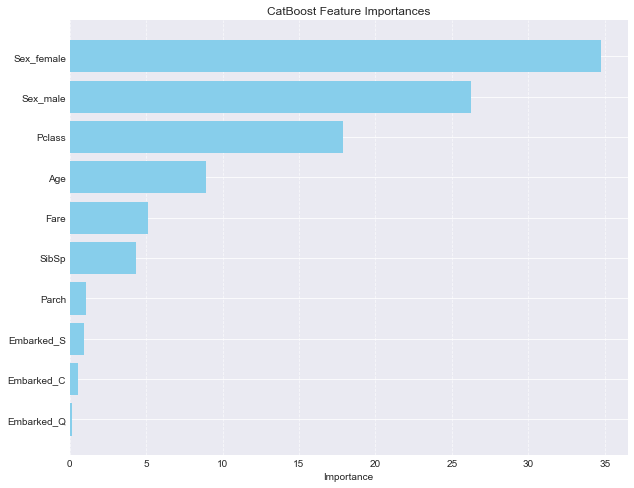

In [234]:
# CatBoost
# Получение важности признаков
cat_feature_importances = cat_model.get_feature_importance()

# Сортировка признаков по важности
indices = np.argsort(cat_feature_importances)[::-1]
sorted_importances = cat_feature_importances[indices]
sorted_feature_names = X.columns[indices]

# Настройка графика
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('CatBoost Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавление сетки
plt.gca().invert_yaxis()  # Инвертирование оси Y для отображения наиболее важных признаков сверху
plt.show()


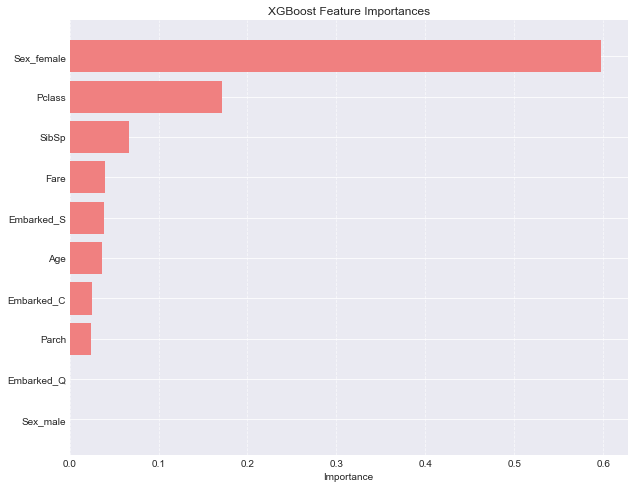

In [235]:
# XGBoost
xgb_feature_importances = xgb_model.feature_importances_
# Сортировка признаков по важности
indices = np.argsort(xgb_feature_importances)[::-1]
sorted_importances = xgb_feature_importances[indices]
sorted_feature_names = X.columns[indices]

# Настройка графика
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances, color='lightcoral')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавление сетки для удобства восприятия
plt.gca().invert_yaxis()  # Инвертирование оси Y для отображения наиболее важных признаков сверху
plt.show()




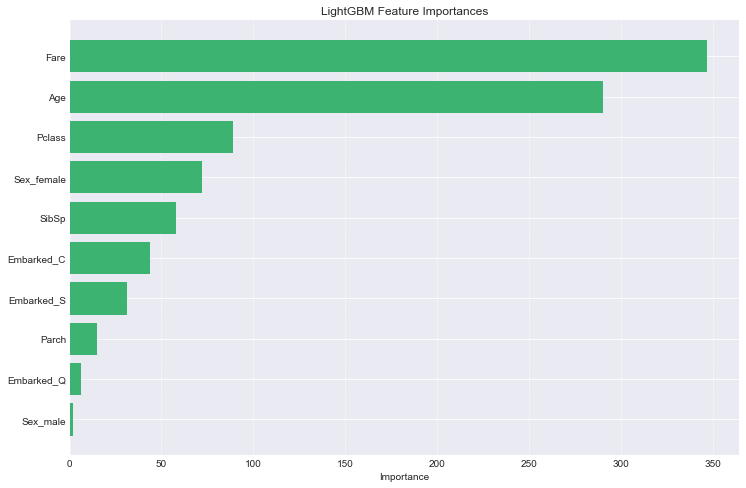

In [236]:
# LightGBM
lgb_feature_importances = lgb_model.feature_importances_
# Сортировка признаков по важности
indices = np.argsort(lgb_feature_importances)[::-1]
sorted_importances = lgb_feature_importances[indices]
sorted_feature_names = X.columns[indices]

# Настройка графика
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importances, color='mediumseagreen')
plt.xlabel('Importance')
plt.title('LightGBM Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавление сетки для удобства восприятия
plt.gca().invert_yaxis()  # Инвертирование оси Y для отображения наиболее важных признаков сверху
plt.show()


**Выводы:**

Пол (Sex) является важным признаком в CatBoost и XGBoost, но LightGBM придает большее значение стоимости билета (Fare).

Класс билета (Pclass) и возраст (Age) consistently важны во всех трех моделях, что подтверждает их значимость для предсказания выживаемости.

Признаки, связанные с местом посадки (Embarked) и количеством родственников на борту (SibSp, Parch) имеют меньшую важность, что может указывать на то, что они не так критичны для предсказания выживаемости в данном наборе данных.

LightGBM демонстрирует наилучшие результаты по точности и F1-score, что делает его предпочтительным выбором для данной задачи.

CatBoost показывает наилучшие результаты по точности, но уступает в полноте и F1-score.

XGBoost имеет наилучший показатель полноты, но его точность и F1-score ниже, чем у других моделей.

В дальнейшем рекомендуются выполнить подбор гиперпараметров для лучшего качества.